# Setup Imports


Code from: https://arena-ch1-transformers.streamlit.app/[1.3]_Indirect_Object_Identification

In [1]:
try:
    import google.colab # type: ignore
    IN_COLAB = True
except:
    IN_COLAB = False

import os, sys

if IN_COLAB:
    # Install packages
    %pip install einops
    %pip install jaxtyping
    %pip install transformer_lens
    %pip install git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python

    # Code to download the necessary files (e.g. solutions, test funcs)
    import os, sys
    if not os.path.exists("chapter1_transformers"):
        !curl -o /content/main.zip https://codeload.github.com/callummcdougall/ARENA_2.0/zip/refs/heads/main
        !unzip /content/main.zip 'ARENA_2.0-main/chapter1_transformers/exercises/*'
        sys.path.append("/content/ARENA_2.0-main/chapter1_transformers/exercises")
        os.remove("/content/main.zip")
        os.rename("ARENA_2.0-main/chapter1_transformers", "chapter1_transformers")
        os.rmdir("ARENA_2.0-main")
        os.chdir("chapter1_transformers/exercises")
else:
    from IPython import get_ipython
    ipython = get_ipython()
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 851.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.0/119.0 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [2]:
import os; os.environ["ACCELERATE_DISABLE_RICH"] = "1"
import sys
from pathlib import Path
import torch as t
from torch import Tensor
import numpy as np
import einops
from tqdm.notebook import tqdm
import plotly.express as px
import webbrowser
import re
import itertools
from jaxtyping import Float, Int, Bool
from typing import List, Optional, Callable, Tuple, Dict, Literal, Set
from functools import partial
from IPython.display import display, HTML
from rich.table import Table, Column
from rich import print as rprint
import circuitsvis as cv
from pathlib import Path
from transformer_lens.hook_points import HookPoint
from transformer_lens import utils, HookedTransformer, ActivationCache
from transformer_lens.components import Embed, Unembed, LayerNorm, MLP

t.set_grad_enabled(False)

# Make sure exercises are in the path
chapter = r"chapter1_transformers"
exercises_dir = Path(f"{os.getcwd().split(chapter)[0]}/{chapter}/exercises").resolve()
section_dir = (exercises_dir / "part3_indirect_object_identification").resolve()
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

from plotly_utils import imshow, line, scatter, bar
import part3_indirect_object_identification.tests as tests

device = t.device("cuda") if t.cuda.is_available() else t.device("cpu")

MAIN = __name__ == "__main__"

/usr/local/lib/python3.10/dist-packages/accelerate/utils/imports.py:193: UserWarning: `ACCELERATE_DISABLE_RICH` is deprecated and will be removed in v0.22.0 and deactivated by default. Please use `ACCELERATE_ENABLE_RICH` if you wish to use `rich`.
  warnings.warn(


In [3]:
from part3_indirect_object_identification.ioi_dataset import NAMES, IOIDataset

## Load Model, Data, and Functions

In [4]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2-small into HookedTransformer


# Generate dataset with multiple prompts

In [25]:
import torch

In [26]:
class Dataset:
    def __init__(self, prompts, pos_dict, tokenizer, S1_is_first=False):
        self.prompts = prompts
        self.tokenizer = tokenizer
        self.N = len(prompts)
        self.max_len = max(
            [
                len(self.tokenizer(prompt["text"]).input_ids)
                for prompt in self.prompts
            ]
        )
        # all_ids = [prompt["TEMPLATE_IDX"] for prompt in self.ioi_prompts]
        all_ids = [0 for prompt in self.prompts] # only 1 template
        all_ids_ar = np.array(all_ids)
        self.groups = []
        for id in list(set(all_ids)):
            self.groups.append(np.where(all_ids_ar == id)[0])

        texts = [ prompt["text"] for prompt in self.prompts ]
        self.toks = torch.Tensor(self.tokenizer(texts, padding=True).input_ids).type(
            torch.int
        )
        self.corr_tokenIDs = [
            # self.tokenizer.encode(" " + prompt["corr"])[0] for prompt in self.prompts
            self.tokenizer.encode(prompt["corr"])[0] for prompt in self.prompts
        ]
        self.incorr_tokenIDs = [
            # self.tokenizer.encode(" " + prompt["incorr"])[0] for prompt in self.prompts
            self.tokenizer.encode(prompt["incorr"])[0] for prompt in self.prompts
        ]

        # word_idx: for every prompt, find the token index of each target token and "end"
        # word_idx is a tensor with an element for each prompt. The element is the targ token's ind at that prompt
        self.word_idx = {}
        # for targ in [key for key in self.prompts[0].keys() if (key != 'text' and key != 'corr' and key != 'incorr')]:
        for targ in [key for key in pos_dict]:
            targ_lst = []
            for prompt in self.prompts:
                input_text = prompt["text"]
                tokens = model.tokenizer.tokenize(input_text)
                # if S1_is_first and targ == "S1":  # only use this if first token doesn't have space Ġ in front
                #     target_token = prompt[targ]
                # else:
                #     target_token = "Ġ" + prompt[targ]
                # target_index = tokens.index(target_token)
                target_index = pos_dict[targ]
                targ_lst.append(target_index)
            self.word_idx[targ] = torch.tensor(targ_lst)

        targ_lst = []
        for prompt in self.prompts:
            input_text = prompt["text"]
            tokens = self.tokenizer.tokenize(input_text)
            end_token_index = len(tokens) - 1
            targ_lst.append(end_token_index)
        self.word_idx["end"] = torch.tensor(targ_lst)

    def __len__(self):
        return self.N

In [27]:
import pickle

prompts_list = []

temps = ['done', 'lost', 'names']

for i in temps:
    file_name = f'/content/digits_prompts_{i}.pkl'
    with open(file_name, 'rb') as file:
        filelist = pickle.load(file)

    print(filelist[0]['text'])
    prompts_list += filelist [:512] #768 512

len(prompts_list)
prompts_list = prompts_list[:50]

Van done in 1. Hat done in 2. Ring done in 3. Desk done in 4. Sun done in
Oil lost in 1. Apple lost in 2. Tree lost in 3. Snow lost in 4. Apple lost in
Marcus born in 1. Victoria born in 2. George born in 3. Brandon born in 4. Jamie born in


In [28]:
# pos_dict = {
#     'S1': 4,
#     'S2': 10,
#     'S3': 16,
#     'S4': 22,
# }

pos_dict = {}
for i in range(len(model.tokenizer.tokenize(prompts_list[0]['text']))):
    pos_dict['S'+str(i)] = i

# pos_dict

In [29]:
dataset = Dataset(prompts_list, pos_dict, model.tokenizer, S1_is_first=True)

In [30]:
dataset_1 = dataset

In [31]:
# import random

# def generate_prompts_list_corr(prompt_list):
#     outlist = []
#     for prompt_dict in prompts_list:
#         r1 = random.randint(1, 12)
#         r2 = random.randint(1, 12)
#         while True:
#             r3 = random.randint(1, 12)
#             r4 = random.randint(1, 12)
#             if r4 - 1 != r3:
#                 break
#         new_text = prompt_dict['text'].replace(prompt_dict['S1'], str(r1)).replace(prompt_dict['S2'], str(r2)).replace(prompt_dict['S3'], str(r3)).replace(prompt_dict['S4'], str(r4))
#         new_prompt_dict = {
#             'S1': str(r1),
#             'S2': str(r2),
#             'S3': str(r3),
#             'S4': str(r4),
#             'corr': prompt_dict['corr'],
#             'incorr': prompt_dict['incorr'],
#             'text': new_text
#         }
#         outlist.append(new_prompt_dict)
#     return outlist
# prompts_list_2 = generate_prompts_list_corr(prompts_list)

In [32]:
import pickle
file_name = '/content/randDS_numerals.pkl'
with open(file_name, 'rb') as file:
    prompts_list_2 = pickle.load(file)

In [33]:
prompts_list_2 = prompts_list_2[:50]

In [34]:
dataset_2 = Dataset(prompts_list_2, pos_dict, model.tokenizer, S1_is_first=True)

# Path patching fns

## Performance Metrics

In [35]:
import gc

# del(ioi_cache)
# del(ioi_logits_original)

torch.cuda.empty_cache()
gc.collect()

0

In [41]:
def logits_to_ave_logit_diff_2(logits: Float[Tensor, "batch seq d_vocab"], dataset_1: IOIDataset = dataset_1, per_prompt=False):
    '''
    Returns logit difference between the correct and incorrect answer.

    If per_prompt=True, return the array of differences rather than the average.
    '''

    # Only the final logits are relevant for the answer
    # Get the logits corresponding to the indirect object / subject tokens respectively
    corr_logits: Float[Tensor, "batch"] = logits[range(logits.size(0)), dataset_1.word_idx["end"], dataset_1.corr_tokenIDs]
    incorr_logits: Float[Tensor, "batch"] = logits[range(logits.size(0)), dataset_1.word_idx["end"], dataset_1.incorr_tokenIDs]
    # Find logit difference
    answer_logit_diff = corr_logits - incorr_logits
    return answer_logit_diff if per_prompt else answer_logit_diff.mean()

model.reset_hooks(including_permanent=True)

ioi_logits_original, ioi_cache = model.run_with_cache(dataset_1.toks)
abc_logits_original, abc_cache = model.run_with_cache(dataset_2.toks)

ioi_per_prompt_diff = logits_to_ave_logit_diff_2(ioi_logits_original, per_prompt=True)
abc_per_prompt_diff = logits_to_ave_logit_diff_2(abc_logits_original, per_prompt=True)

ioi_average_logit_diff = logits_to_ave_logit_diff_2(ioi_logits_original).item()
abc_average_logit_diff = logits_to_ave_logit_diff_2(abc_logits_original).item()

In [42]:
def ioi_metric_2(
    logits: Float[Tensor, "batch seq d_vocab"],
    clean_logit_diff: float = ioi_average_logit_diff,
    corrupted_logit_diff: float = abc_average_logit_diff,
    dataset_1: IOIDataset = dataset_1,
) -> float:
    '''
    We calibrate this so that the value is 0 when performance isn't harmed (i.e. same as IOI dataset),
    and -1 when performance has been destroyed (i.e. is same as ABC dataset).
    '''
    patched_logit_diff = logits_to_ave_logit_diff_2(logits, dataset_1)
    return (patched_logit_diff - clean_logit_diff) / (clean_logit_diff - corrupted_logit_diff)


print(f"IOI metric (IOI dataset): {ioi_metric_2(ioi_logits_original):.4f}")
print(f"IOI metric (ABC dataset): {ioi_metric_2(abc_logits_original):.4f}")

IOI metric (IOI dataset): 0.0000
IOI metric (ABC dataset): -1.0000


0 means performance is the same as on the IOI dataset (i.e. hasn't been harmed in any way), and -1 means performance is the same as on the ABC dataset (i.e. the model has completely lost the ability to distinguish between the subject and indirect object).


## old fn

In [ ]:

# def get_path_patch_head_to_final_resid_post(
#     model: HookedTransformer,
#     patching_metric: Callable,
#     new_dataset: IOIDataset = dataset_2,
#     orig_dataset: IOIDataset = dataset_1,
#     new_cache: Optional[ActivationCache] = abc_cache,
#     orig_cache: Optional[ActivationCache] = ioi_cache,
# ) -> Float[Tensor, "layer head"]:
#     '''
#     Performs path patching (see algorithm in appendix B of IOI paper), with:

#         sender head = (each head, looped through, one at a time)
#         receiver node = final value of residual stream

#     Returns:
#         tensor of metric values for every possible sender head
#     '''
#     model.reset_hooks()
#     results = t.zeros(model.cfg.n_layers, model.cfg.n_heads, device="cuda", dtype=t.float32)

#     resid_post_hook_name = utils.get_act_name("resid_post", model.cfg.n_layers - 1)
#     resid_post_name_filter = lambda name: name == resid_post_hook_name


#     # ========== Step 1 ==========
#     # Gather activations on x_orig and x_new

#     # Note the use of names_filter for the run_with_cache function. Using it means we
#     # only cache the things we need (in this case, just attn head outputs).
#     z_name_filter = lambda name: name.endswith("z")
#     if new_cache is None:
#         _, new_cache = model.run_with_cache(
#             new_dataset.toks,
#             names_filter=z_name_filter,
#             return_type=None
#         )
#     if orig_cache is None:
#         _, orig_cache = model.run_with_cache(
#             orig_dataset.toks,
#             names_filter=z_name_filter,
#             return_type=None
#         )


#     # Looping over every possible sender head (the receiver is always the final resid_post)
#     # Note use of itertools (gives us a smoother progress bar)
#     for (sender_layer, sender_head) in tqdm(list(itertools.product(range(model.cfg.n_layers), range(model.cfg.n_heads)))):

#         # ========== Step 2 ==========
#         # Run on x_orig, with sender head patched from x_new, every other head frozen

#         hook_fn = partial(
#             patch_or_freeze_head_vectors,
#             new_cache=new_cache,
#             orig_cache=orig_cache,
#             head_to_patch=(sender_layer, sender_head),
#         )
#         model.add_hook(z_name_filter, hook_fn)

#         _, patched_cache = model.run_with_cache(
#             orig_dataset.toks,
#             names_filter=resid_post_name_filter,
#             return_type=None
#         )
#         # if (sender_layer, sender_head) == (9, 9):
#         #     return patched_cache
#         assert set(patched_cache.keys()) == {resid_post_hook_name}

#         # ========== Step 3 ==========
#         # Unembed the final residual stream value, to get our patched logits

#         patched_logits = model.unembed(model.ln_final(patched_cache[resid_post_hook_name]))

#         # Save the results
#         results[sender_layer, sender_head] = patching_metric(patched_logits)

#     return results

## path patching mlp edits

In [86]:
# def patch_or_freeze_head_vectors(
def patch_or_freeze_mlp_vectors(
    # orig_head_vector: Float[Tensor, "batch pos head_index d_head"],
    orig_MLP_vector: Float[Tensor, "batch pos d_model"],
    hook: HookPoint,
    new_cache: ActivationCache,
    orig_cache: ActivationCache,
    # head_to_patch: Tuple[int, int],
    layer_to_patch: int,
# ) -> Float[Tensor, "batch pos head_index d_head"]:
) -> Float[Tensor, "batch pos d_model"]:
    '''
    This helps implement step 2 of path patching. We freeze all head outputs (i.e. set them
    to their values in orig_cache), except for head_to_patch (if it's in this layer) which
    we patch with the value from new_cache.

    head_to_patch: tuple of (layer, head)
        we can use hook.layer() to check if the head to patch is in this layer
    '''
    # the layer is hook.layer(), and orig_head_vector is ALREADY an MLP at a layer, so we don't get it by layer
    # we just have to patch in each neuron of the MLP (d_model) that's why dims are "batch pos d_model"

    # Setting using ..., otherwise changing orig_head_vector will edit cache value too
    # this keeps everything the same
    # we NEED this to prevent change by ref!
    # orig_head_vector[...] = orig_cache[hook.name][...]
    # orig_MLP_vector[...] = orig_cache[hook.name][...]

    # this change the one MLP layer
    # if head_to_patch[0] == hook.layer():
    #     orig_head_vector[:, :, head_to_patch[1]] = new_cache[hook.name][:, :, head_to_patch[1]]

    # set the entire sender head as new (corr) cache output actvs
    if layer_to_patch == hook.layer():
        orig_MLP_vector[:, :, :] = new_cache[hook.name][:, :, :]
    return orig_MLP_vector

In [87]:
import pdb

In [88]:
def patch_mlp_input(
# def patch_head_input(
    # orig_activation: Float[Tensor, "batch pos head_idx d_head"],
    orig_activation: Float[Tensor, "batch pos d_model"],
    hook: HookPoint,
    patched_cache: ActivationCache,
    # head_list: List[Tuple[int, int]],
    layer_list: List[int],
) -> Float[Tensor, "batch pos head_idx d_head"]:
    '''
    Function which can patch any combination of heads in layers,
    according to the heads in head_list.
    '''
    # heads_to_patch = [head for layer, head in head_list if layer == hook.layer()]  # we dont need list, just layer int
    # orig_activation[:, :, heads_to_patch] = patched_cache[hook.name][:, :, heads_to_patch] # heads_to_patch should now be an int, layer?

    # exact same thing as before, since we don't need to freeze other heads, so uinlike
    # w/ attn heads, this is the same fn. we can just re-use the prev one instead of this one
    # we also don't have a head list, but an MLP list
    # ACCTU this is diff; there's al ist of layer ints, and only if layer in list do we patch

    # orig_activation[...] = orig_cache[hook.name][...]  # we dont need this? but by ref? postpone thinking this

    if hook.layer() in layer_list:
        # pdb.set_trace()
        orig_activation[:, :, :] = patched_cache[hook.name][:, :, :]
    return orig_activation

"""
receiver_heads are from the circuit. we loop thru all sender thats that go into them
these senders can be both MLP or head

get_path_patch_head_to_heads() is for a list of receiver heads, from all sender heads.
the sender heads are used in step 2, with patch_or_freeze_head_vectors().
the receiver heads are used in step 3, with patch_head_input().

step 2 obtains a cache for receiver head activations which are patched in at step 3.
run with hooks takes a list of actvs and patches them all in.

step 3 is head or MLP specific. thus, we need four fns:
get_path_patch_MLPs_to_MLPs
get_path_patch_MLPs_to_heads
get_path_patch_heads_to_MLPs
get_path_patch_heads_to_heads

we can also combine the senders into one:
get_path_patch_MLPs
etc

but results works on [layer, head], and is a 2D tensor. we can have another results
that's just a 1D tensor for MLPs.

results_dict[receiver_head] = logit_diff for every component = result
head_adjList[head] = edges_within_threshold(result, Ethres)
we can also do edges_within_threshold on a 1D tensor for MLPs.
then head_from_MLP_adjList is head:MLP for MLP -> heads

step 2:
Thus, we need both patch_or_freeze_head_vectors() and patch_or_freeze_MLP_vectors()
because both heads and MLPs can be sender heads (not from circ, but looping thru all)

however, with our circuit, we can loop thru all the heads in circuit, NOT
model.cfg.n_heads.

"""

def get_path_patch_MLPs_to_MLPs(
# def get_path_patch_head_to_heads(
    # receiver_heads: List[Tuple[int, int]],
    receiver_layers: List[int],
    # receiver_input: str,
    model: HookedTransformer,
    patching_metric: Callable,
    new_dataset: IOIDataset = dataset_2,
    orig_dataset: IOIDataset = dataset_1,
    new_cache: Optional[ActivationCache] = None,
    orig_cache: Optional[ActivationCache] = None,
) -> Float[Tensor, "layer head"]:
    '''
    Performs path patching (see algorithm in appendix B of IOI paper), with:

        sender head = (each head, looped through, one at a time)
        receiver node = input to a later head (or set of heads)

    The receiver node is specified by receiver_heads and receiver_input.
    Example (for S-inhibition path patching the queries):
        receiver_heads = [(8, 6), (8, 10), (7, 9), (7, 3)],
        receiver_input = "v"

    Returns:
        tensor of metric values for every possible sender head
    '''
    model.reset_hooks()

    # assert receiver_input in ("k", "q", "v")  # we can run get_path_patch_head_to_heads() 3 times for k, q, v!
    # receiver_layers = set(next(zip(*receiver_heads)))
    # receiver_hook_names = [utils.get_act_name(receiver_input, layer) for layer in receiver_layers]
    receiver_hook_names = [utils.get_act_name('mlp_out', layer) for layer in receiver_layers]  # modify for mlp_out
    receiver_hook_names_filter = lambda name: name in receiver_hook_names

    # results = t.zeros(max(receiver_layers), model.cfg.n_heads, device="cuda", dtype=t.float32)
    results = t.zeros(max(receiver_layers), device="cuda", dtype=t.float32)

    # ========== Step 1 ==========
    # z_name_filter = lambda name: name.endswith("z")
    z_name_filter = lambda name: name.endswith("mlp_out")

    if new_cache is None:
        _, new_cache = model.run_with_cache(
            new_dataset.toks,
            names_filter=z_name_filter,
            return_type=None
        )
    if orig_cache is None:
        _, orig_cache = model.run_with_cache(
            orig_dataset.toks,
            names_filter=z_name_filter,
            return_type=None
        )

    # Note, the sender layer will always be before the final receiver layer, otherwise there will
    # be no causal effect from sender -> receiver. So we only need to loop this far.

    # for (sender_layer, sender_head) in tqdm(list(itertools.product(
    #     range(max(receiver_layers)),  # all the layers from 0 to highest receiver layer (in circuit)
    #     range(model.cfg.n_heads)  # all heads from 0 to 12
    # ))):

    # have a separate loop for both MLPs AND heads as senders
    for (sender_layer) in range(max(receiver_layers)):  # all the layers from 0 to highest receiver layer (in circuit)

        # ========== Step 2 ==========
        # Run on x_orig, with sender head patched from x_new, every other head frozen

        hook_fn = partial(
            # patch_or_freeze_head_vectors,
            patch_or_freeze_mlp_vectors,
            new_cache=new_cache,
            orig_cache=orig_cache,
            # head_to_patch=(sender_layer, sender_head),
            layer_to_patch = sender_layer # an int
        )

        model.add_hook(z_name_filter, hook_fn, level=1)

        _, patched_cache = model.run_with_cache(
            orig_dataset.toks,
            names_filter=receiver_hook_names_filter,
            return_type=None
        )
        # model.reset_hooks(including_permanent=True)
        # assert set(patched_cache.keys()) == set(receiver_hook_names)

        # ========== Step 3 ==========
        # Run on x_orig, patching in the receiver node(s) from the previously cached value

        hook_fn = partial(
            # patch_head_input,
            patch_mlp_input,
            patched_cache=patched_cache,
            # head_list=receiver_heads, # list of layer ints
            layer_list=receiver_layers,
        )
        patched_logits = model.run_with_hooks(
            orig_dataset.toks,
            fwd_hooks = [(receiver_hook_names_filter, hook_fn)],
            return_type="logits"
        )

        # Save the results
        # results[sender_layer, sender_head] = patching_metric(patched_logits)
        results[sender_layer] = patching_metric(patched_logits)

    # the result is which sender layers affect ALL the inputted nodes. this is why we just
    # want to pass one node at a time- to see which layers affect just IT.
    # if we want a 'group of nodes under a common type', we'd pass a set of nodes
    return results

## explr tests

In [ ]:
head = (9, 1)

model.reset_hooks()
result = get_path_patch_head_to_heads(
    receiver_heads = [head],
    receiver_input = "v",
    model = model,
    patching_metric = ioi_metric_2
)
results_dict[head] = result

# %%capture
# results_dict = {}
# for head in circuit:
#     model.reset_hooks()
#     result = get_path_patch_head_to_heads(
#         receiver_heads = [head],
#         receiver_input = "v",
#         model = model,
#         patching_metric = ioi_metric_2
#     )
#     results_dict[head] = result

In [59]:
receiver_heads = [(1,1), (1,2), (3,3)]
receiver_layers = set(next(zip(*receiver_heads)))
receiver_layers

{1, 3}

In [61]:
receiver_input = 'v'
receiver_hook_names = [utils.get_act_name(receiver_input, layer) for layer in receiver_layers]
receiver_hook_names

['blocks.1.attn.hook_v', 'blocks.3.attn.hook_v']

In [63]:
mlp_hook_names = [utils.get_act_name('mlp_out', layer) for layer in [4, 5, 7]]
mlp_hook_names  # 'blocks.1.hook_mlp_out'

['blocks.4.hook_mlp_out', 'blocks.5.hook_mlp_out', 'blocks.7.hook_mlp_out']

In [ ]:
def patch_or_freeze_head_vectors(
    orig_head_vector: Float[Tensor, "batch pos head_index d_head"],
    hook: HookPoint,
    new_cache: ActivationCache,
    orig_cache: ActivationCache,
    head_to_patch: Tuple[int, int],
) -> Float[Tensor, "batch pos head_index d_head"]:
    '''
    This helps implement step 2 of path patching. We freeze all head outputs (i.e. set them
    to their values in orig_cache), except for head_to_patch (if it's in this layer) which
    we patch with the value from new_cache.

    head_to_patch: tuple of (layer, head)
        we can use hook.layer() to check if the head to patch is in this layer
    '''
    # Setting using ..., otherwise changing orig_head_vector will edit cache value too
    orig_head_vector[...] = orig_cache[hook.name][...]
    if head_to_patch[0] == hook.layer():
        orig_head_vector[:, :, head_to_patch[1]] = new_cache[hook.name][:, :, head_to_patch[1]]
    return orig_head_vector

In [51]:
z_name_filter = lambda name: name.endswith("z")

_, new_cache = model.run_with_cache(
        dataset_2.toks,
        names_filter=z_name_filter,
        return_type=None
    )

_, orig_cache = model.run_with_cache(
        dataset_1.toks,
        names_filter=z_name_filter,
        return_type=None
    )

In [52]:
orig_cache.keys()

dict_keys(['blocks.0.attn.hook_z', 'blocks.1.attn.hook_z', 'blocks.2.attn.hook_z', 'blocks.3.attn.hook_z', 'blocks.4.attn.hook_z', 'blocks.5.attn.hook_z', 'blocks.6.attn.hook_z', 'blocks.7.attn.hook_z', 'blocks.8.attn.hook_z', 'blocks.9.attn.hook_z', 'blocks.10.attn.hook_z', 'blocks.11.attn.hook_z'])

In [54]:
orig_cache['blocks.0.attn.hook_z'][...].size()

torch.Size([50, 23, 12, 64])

In [55]:
z_name_filter = lambda name: name.endswith("mlp_out")

_, new_cache = model.run_with_cache(
        dataset_2.toks,
        names_filter=z_name_filter,
        return_type=None
    )

_, orig_cache = model.run_with_cache(
        dataset_1.toks,
        names_filter=z_name_filter,
        return_type=None
    )

In [45]:
orig_cache.keys()

dict_keys(['blocks.0.hook_mlp_out', 'blocks.1.hook_mlp_out', 'blocks.2.hook_mlp_out', 'blocks.3.hook_mlp_out', 'blocks.4.hook_mlp_out', 'blocks.5.hook_mlp_out', 'blocks.6.hook_mlp_out', 'blocks.7.hook_mlp_out', 'blocks.8.hook_mlp_out', 'blocks.9.hook_mlp_out', 'blocks.10.hook_mlp_out', 'blocks.11.hook_mlp_out'])

In [47]:
# this sets the vector to orig actvs
# orig_MLP_vector[...] = orig_cache['blocks.0.hook_mlp_out'][...]
# orig_head_vector: Float[Tensor, "batch pos d_model"],

# orig_cache[hook.name][...]
# this sets everything in mlp out. we can actully SKIP this b/c its purpose
# before was to make every head except the head of interest (sender) the orig.
# but in MLP, there are no other heads
orig_cache['blocks.0.hook_mlp_out'][...].size()

torch.Size([50, 23, 768])

In [50]:
orig_MLP_vector = orig_cache['blocks.0.hook_mlp_out']
orig_MLP_vector[:, :, :].size()

torch.Size([50, 23, 768])

In [57]:
# since we're not targeting a specific head, we can just use this,
# and not = new_cache[hook.name][:, :, head_to_patch[1]]
# unlike before, which need to target a head in the attn layer, we dont
# target a specific neuron of the d_model neurons in mlp_out

orig_MLP_vector[:, :, :] = new_cache['blocks.0.hook_mlp_out'][:, :, :]
orig_MLP_vector.size()

torch.Size([50, 23, 768])

So it has dims batch seqlen d_model

In [ ]:
def patch_head_input(
    orig_activation: Float[Tensor, "batch pos head_idx d_head"],
    hook: HookPoint,
    patched_cache: ActivationCache,
    head_list: List[Tuple[int, int]],
) -> Float[Tensor, "batch pos head_idx d_head"]:
    '''
    Function which can patch any combination of heads in layers,
    according to the heads in head_list.
    '''
    heads_to_patch = [head for layer, head in head_list if layer == hook.layer()]
    orig_activation[:, :, heads_to_patch] = patched_cache[hook.name][:, :, heads_to_patch]
    return orig_activation

In [ ]:
# head_to_patch: tuple of (layer, head)
# heads_to_patch = [head for layer, head in head_list if layer == hook.layer()]
# change this to an int for layer

# orig_activation: Float[Tensor, "batch pos head_idx d_head"],
# change this to Float[Tensor, "batch pos d_model"],

# orig_activation[:, :, heads_to_patch] = patched_cache[hook.name][:, :, heads_to_patch]

 step two breakdown

In [66]:
# this is the loop that BOTH step 2 and 3 are in (repeat both for all sender (L,H) in this list )

# tqdm(list(itertools.product(
#         range(max(receiver_layers)),  # all the layers from 0 to highest receiver layer (in circuit)
#         range(model.cfg.n_heads)  # all heads from 0 to 12
#     )))

list(itertools.product(
        range(max(receiver_layers)),  # all the layers from 0 to highest receiver layer (in circuit)
        range(model.cfg.n_heads)  # all heads from 0 to 12
    ))


[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 9),
 (0, 10),
 (0, 11),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (1, 6),
 (1, 7),
 (1, 8),
 (1, 9),
 (1, 10),
 (1, 11),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 10),
 (2, 11)]

In [67]:
tqdm(list(itertools.product(
        range(max(receiver_layers)),  # all the layers from 0 to highest receiver layer (in circuit)
        range(model.cfg.n_heads)  # all heads from 0 to 12
    )))

  0%|          | 0/36 [00:00<?, ?it/s]

In [ ]:
# _, patched_cache = model.run_with_cache(
#             orig_dataset.toks,
#             names_filter=receiver_hook_names_filter,
#             return_type=None
#         )
# patched_cache.keys()

## test new fns mlp

MLP to MLP says which MLPs affect other MLPs

In [76]:
receiver_layers = [2, 4, 6]
results_dict = {}

model.reset_hooks()
result = get_path_patch_MLPs_to_MLPs(
    receiver_layers = receiver_layers,
    # receiver_input = "v",
    model = model,
    patching_metric = ioi_metric_2
)
result  # tensor of metric values for every possible sender head affecting ALL rece layers, not just 1

tensor([ 0.0000,  0.0000, -0.0522,  0.0000, -0.1603,  0.0000], device='cuda:0')

In [77]:
receiver_layers = [4]
results_dict = {}

model.reset_hooks()
result = get_path_patch_MLPs_to_MLPs(
    receiver_layers = receiver_layers,
    # receiver_input = "v",
    model = model,
    patching_metric = ioi_metric_2
)
result  # tensor of metric values for every possible sender head affecting ALL rece layers, not just 1

tensor([0., 0., 0., 0.], device='cuda:0')

In [79]:
for layer in range(12):
    model.reset_hooks()
    result = get_path_patch_MLPs_to_MLPs(
        receiver_layers = [layer],
        # receiver_input = "v",
        model = model,
        patching_metric = ioi_metric_2
    )
    print(layer, result)

0 tensor([], device='cuda:0')
1 tensor([0.], device='cuda:0')
2 tensor([0., 0.], device='cuda:0')
3 tensor([0., 0., 0.], device='cuda:0')
4 tensor([0., 0., 0., 0.], device='cuda:0')
5 tensor([0., 0., 0., 0., 0.], device='cuda:0')
6 tensor([0., 0., 0., 0., 0., 0.], device='cuda:0')
7 tensor([0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
8 tensor([0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
9 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
10 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
11 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


In [80]:
receiver_layers = [1, 2, 3, 4, 6]
results_dict = {}

model.reset_hooks()
result = get_path_patch_MLPs_to_MLPs(
    receiver_layers = receiver_layers,
    # receiver_input = "v",
    model = model,
    patching_metric = ioi_metric_2
)
result  # tensor of metric values for every possible sender head affecting ALL rece layers, not just 1

tensor([ 0.0000, -0.1201, -0.0956, -0.0093, -0.1603,  0.0000], device='cuda:0')

In [81]:
receiver_layers = [0, 1, 2, 3, 4, 5, 6]
results_dict = {}

model.reset_hooks()
result = get_path_patch_MLPs_to_MLPs(
    receiver_layers = receiver_layers,
    # receiver_input = "v",
    model = model,
    patching_metric = ioi_metric_2
)
result  # tensor of metric values for every possible sender head affecting ALL rece layers, not just 1

tensor([-0.5689, -0.2438, -0.1798,  0.0277, -0.3310, -0.0380], device='cuda:0')

Why is it only non-zero when add in those heads in receiver_layer input? Shouldn't the sender heads be for all before regardless of input? Check fns again.

0 means nothing was ablated; the patched logits is same as original.

In [85]:
receiver_layers = [3]
results_dict = {}

model.reset_hooks()
result = get_path_patch_MLPs_to_MLPs(
    receiver_layers = receiver_layers,
    # receiver_input = "v",
    model = model,
    patching_metric = ioi_metric_2
)
result  # tensor of metric values for every possible sender head affecting ALL rece layers, not just 1


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.10/bdb.py", line 336, in set_trace
    sys.settrace(self.trace_dispatch)



> <ipython-input-84-4ee8b28f997f>(26)patch_mlp_input()
     24     if hook.layer() in layer_list:
     25         pdb.set_trace()
---> 26         orig_activation[:, :, :] = patched_cache[hook.name][:, :, :]
     27     return orig_activation
     28 

ipdb> hook.layer()
3
ipdb> layer_list
[3]
ipdb> patched_cache[hook.name].size()
torch.Size([50, 23, 768])
ipdb> patched_cache[hook.name][0]
tensor([[-0.3071, -0.3054, -0.3611,  ..., -0.3200, -0.2901, -0.3121],
        [ 0.2406, -0.1419, -0.1391,  ...,  0.1135, -0.7620, -0.2904],
        [-0.1105, -0.5317,  0.4218,  ..., -0.5374, -0.1304,  0.4308],
        ...,
        [ 0.5537, -0.0464, -0.3454,  ...,  0.2239, -0.7954, -0.0068],
        [-0.6315,  0.3542, -0.1505,  ...,  0.8335, -0.0600, -0.2789],
        [ 0.1970,  0.0163, -0.1565,  ...,  0.0414,  0.1464,  0.0321]],
       device='cuda:0')
ipdb> patched_cache[hook.name][0].size()
torch.Size([23, 768])
ipdb> patched_cache[hook.name][0][0]
tensor([-3.0707e-01, -3.0536e-01, -3.6113e-01, -3.


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.10/bdb.py", line 361, in set_quit
    sys.settrace(None)



patched_cache and orig_activation are the same value!

seems like an issue with step 2's fn. try getting rid of

orig_MLP_vector[...] = orig_cache[hook.name][...]

In [89]:
receiver_layers = [3]
results_dict = {}

model.reset_hooks()
result = get_path_patch_MLPs_to_MLPs(
    receiver_layers = receiver_layers,
    # receiver_input = "v",
    model = model,
    patching_metric = ioi_metric_2
)
result  # tensor of metric values for every possible sender head affecting ALL rece layers, not just 1

tensor([-0.0538, -0.0211, -0.0102], device='cuda:0')

That fixes it! Everything's no longer 0. Seems like that set wasn't necessary for MLPs; it just made it not able to be set.

In [90]:
for layer in range(12):
    model.reset_hooks()
    result = get_path_patch_MLPs_to_MLPs(
        receiver_layers = [layer],
        model = model,
        patching_metric = ioi_metric_2
    )
    print(layer, result)

0 tensor([], device='cuda:0')
1 tensor([-0.2165], device='cuda:0')
2 tensor([-0.0581, -0.0181], device='cuda:0')
3 tensor([-0.0538, -0.0211, -0.0102], device='cuda:0')
4 tensor([-0.1030, -0.0079,  0.0093, -0.0339], device='cuda:0')
5 tensor([-0.0883,  0.0466,  0.0391,  0.0053,  0.0263], device='cuda:0')
6 tensor([-0.1497, -0.0216, -0.0120, -0.0003,  0.0159, -0.0670], device='cuda:0')
7 tensor([-0.1348, -0.0138, -0.0088,  0.0060, -0.0249, -0.0645, -0.0018],
       device='cuda:0')
8 tensor([-0.2078,  0.0125, -0.0003, -0.0251,  0.0379, -0.0342,  0.0429, -0.0023],
       device='cuda:0')
9 tensor([-0.6974, -0.1431, -0.0442, -0.0176, -0.1030, -0.0826, -0.0563, -0.1025,
        -0.0965], device='cuda:0')
10 tensor([-0.3297, -0.0374, -0.0012, -0.0029, -0.0215, -0.0224, -0.0343, -0.0407,
        -0.0770, -0.1180], device='cuda:0')
11 tensor([-0.2096, -0.0531, -0.0157,  0.0068, -0.0592,  0.0002, -0.0419, -0.0666,
        -0.0735, -0.0927, -0.0387], device='cuda:0')


## threshold and plot

In [ ]:
def edges_within_threshold(results: torch.Tensor, threshold: float = 0.05) -> list:
    """Return the (layer, head) pairs where the absolute values in results are within a threshold."""

    # Take the absolute value of the results tensor
    abs_tensor = torch.abs(results)

    # Find indices where values exceed the threshold
    indices = (abs_tensor > threshold).nonzero().squeeze()

    # Convert indices to (layer, head) pairs based on dimensions
    if indices.dim() == 1:  # If we got a single-dimensional tensor, it means we only have one match
        layers = [indices[0].item()]
        heads = [indices[1].item()]
    else:
        layers = indices[:, 0].tolist()
        heads = indices[:, 1].tolist()

    return list(zip(layers, heads))

In [ ]:
from graphviz import Digraph, Source
from IPython.display import display
from google.colab import files

def plot_graph_adjacency(head_adjList, filename="circuit_graph", highlighted_nodes=None):
    dot = Digraph()

    if highlighted_nodes is None:
        highlighted_nodes = []

    # Helper function to get node color
    def get_node_color(node):
        return "#E6E6FA" if node in highlighted_nodes else "white"

    # Iterate through the dictionary
    for end_node, start_nodes_list in head_adjList.items():
        # Ensure end_node is present as a node in the graph with potential color
        endNodeColor = get_node_color(end_node)
        if endNodeColor == "#E6E6FA":
            dot.node(str(end_node), color=endNodeColor, style='filled')
        else:
            dot.node(str(end_node))

        for start in start_nodes_list:
            startNodeColor = get_node_color(start)
            if startNodeColor == "#E6E6FA":
                dot.node(str(start), color=startNodeColor, style='filled')
            else:
                dot.node(str(start))
            if startNodeColor == "#E6E6FA" and endNodeColor == "#E6E6FA":
                dot.edge(str(start), str(end_node), color = 'purple', penwidth='2.0')
            else:
                dot.edge(str(start), str(end_node))
            # dot.edge(str(start), str(end_node))

    # Display the graph in Colab
    display(Source(dot.source))

    # Save the graph to a file
    dot.format = 'pdf'  # You can change this to 'pdf', 'png', etc. based on your needs
    dot.render(filename)
    files.download(filename + ".pdf")

greater_than = [(0, 1), (0, 3), (0, 5), (5, 5), (6, 1), (6, 9), (7, 10), (8, 11), (9,1)]

# Path patching expms

## iter patch from 80% fb

https://colab.research.google.com/drive/1mFWmGAKtigFcqqWWMCwU7wWQY2HT5ZOo#scrollTo=lJEY-Zs2g_a5&line=1&uniqifier=1

In [ ]:
circuit = [(1, 5), (3, 3), (3, 7), (3, 10), (3, 11), (4, 4), (4, 6), (4, 7), (4, 10), (4, 11), (5, 0), (5, 2), (5, 3), (5, 4), (5, 6), (6, 3), (6, 8), (6, 10), (7, 0), (7, 2), (7, 7), (7, 8), (7, 10), (7, 11), (8, 0), (8, 1), (8, 6), (8, 8), (8, 9), (8, 11), (9, 1), (11, 8)]
topperc = 10

In [ ]:
%%capture
results_dict = {}
for head in circuit:
    model.reset_hooks()
    result = get_path_patch_head_to_heads(
        receiver_heads = [head],
        receiver_input = "v",
        model = model,
        patching_metric = ioi_metric_2
    )
    results_dict[head] = result

In [ ]:
def thres_at_perc(results_dict, perc):
    # the top perc%
    all_values = []
    for result_tensor in results_dict.values():
        all_values.extend(result_tensor.cpu().numpy().flatten())
    sorted_values = sorted(all_values)

    ind_perc = (100 - perc)/100

    # Calculate the index for the top 10%
    index_10_percent = int(ind_perc * len(sorted_values))

    # Retrieve the value at that index
    value_at_10_percent = sorted_values[index_10_percent]
    return value_at_10_percent

In [ ]:
%%capture
Ethres = thres_at_perc(results_dict, topperc)

head_adjList = {}
for head in circuit:
    result = results_dict[head]
    head_adjList[head] = edges_within_threshold(result, Ethres)

In [ ]:
# only keep nodes that were part of original circuit
all_keys = set(head_adjList.keys())
# Iterate through the dictionary and filter the list values
for key, value in head_adjList.items():
    head_adjList[key] = [item for item in value if item in all_keys]

In [ ]:
# Filter out nodes that don't have outgoing edges except for (9,1) and (10, 7)
# head_adjList = {node: neighbors for node, neighbors in head_adjList.items() if neighbors or node == (9,1) or node == (10,7)}

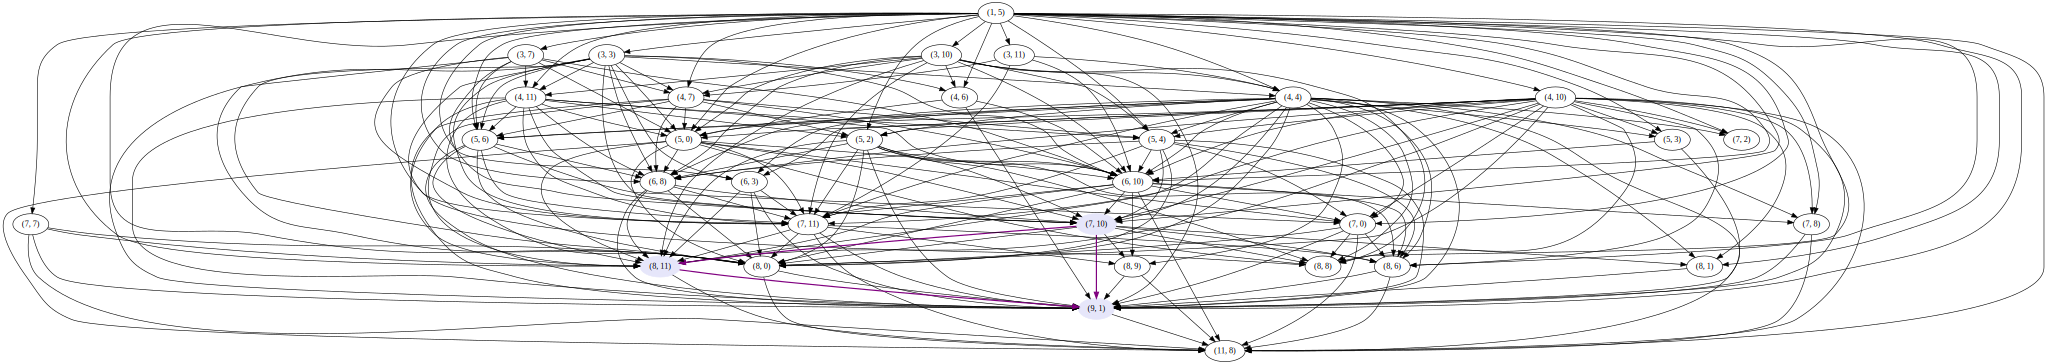

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plot_graph_adjacency(head_adjList, filename="circuit_graph_top"+str(topperc)+"_perc", highlighted_nodes=greater_than)

In [ ]:
import pickle

with open("results_dict.pkl", "wb") as file:
    pickle.dump(results_dict, file)
files.download("results_dict.pkl")

with open("head_adjList.pkl", "wb") as file:
    pickle.dump(head_adjList, file)
files.download("head_adjList.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## iter patch from 97% bf

https://colab.research.google.com/drive/1mFWmGAKtigFcqqWWMCwU7wWQY2HT5ZOo#scrollTo=C2EgKgmJS4qb&line=1&uniqifier=1

In [ ]:
circuit = [(0, 1), (0, 2), (0, 3), (0, 5), (0, 8), (0, 9), (0, 10), (1, 0), (1, 5), (1, 7), (2, 0), (2, 2), (2, 3), (2, 4), (2, 6), (2, 9), (3, 3), (3, 7), (3, 11), (4, 4), (4, 7), (4, 10), (5, 2), (5, 3), (5, 4), (5, 6), (5, 8), (5, 11), (6, 1), (6, 3), (6, 6), (6, 8), (6, 10), (7, 2), (7, 6), (7, 8), (7, 10), (7, 11), (8, 6), (8, 8), (8, 11), (9, 1), (11, 10)]
topperc = 3

In [ ]:
%%capture
results_dict = {}
for head in circuit:
    model.reset_hooks()
    result = get_path_patch_head_to_heads(
        receiver_heads = [head],
        receiver_input = "v",
        model = model,
        patching_metric = ioi_metric_2
    )
    results_dict[head] = result

In [ ]:
def thres_at_perc(results_dict, perc):
    # the top perc%
    all_values = []
    for result_tensor in results_dict.values():
        all_values.extend(result_tensor.cpu().numpy().flatten())
    sorted_values = sorted(all_values)

    ind_perc = (100 - perc)/100

    # Calculate the index for the top %
    index_percent = int(ind_perc * len(sorted_values))

    # Retrieve the value at that index
    value_at_percent = sorted_values[index_percent]
    return value_at_percent

In [ ]:
%%capture
Ethres = thres_at_perc(results_dict, topperc)

head_adjList = {}
for head in circuit:
    result = results_dict[head]
    head_adjList[head] = edges_within_threshold(result, Ethres)

In [ ]:
# only keep nodes that were part of original circuit
all_keys = set(head_adjList.keys())
# Iterate through the dictionary and filter the list values
for key, value in head_adjList.items():
    head_adjList[key] = [item for item in value if item in all_keys]

In [ ]:
# Filter out nodes that don't have outgoing edges except for (9,1) and (10, 7)
# head_adjList = {node: neighbors for node, neighbors in head_adjList.items() if neighbors or node == (9,1) or node == (10,7)}

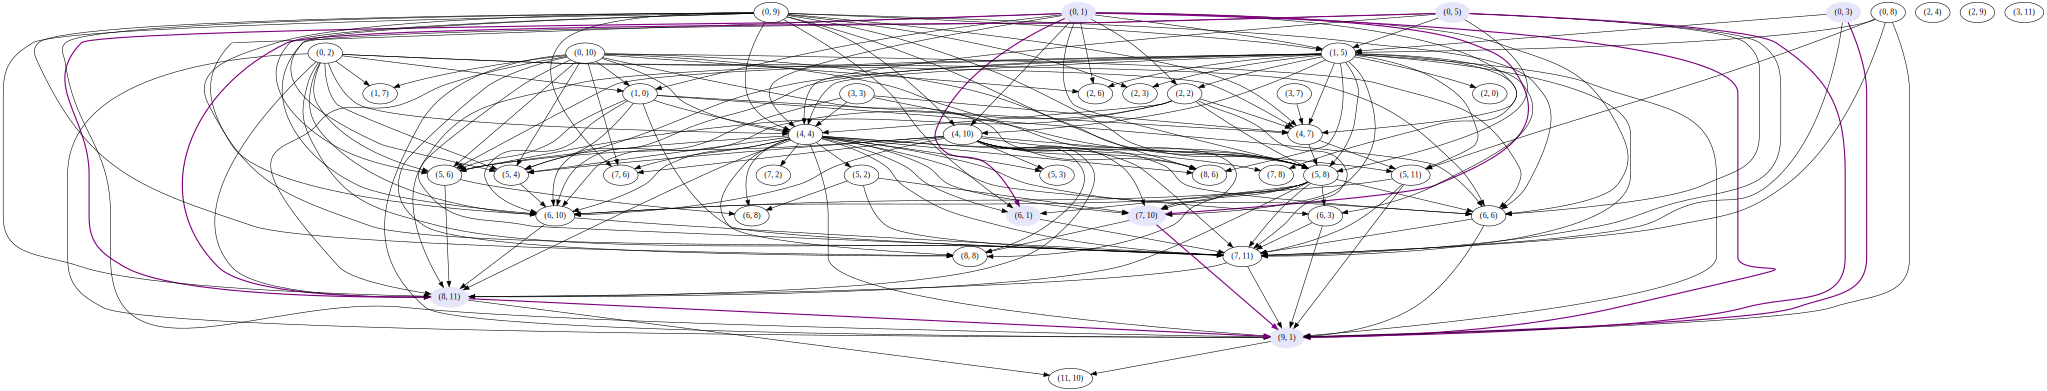

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plot_graph_adjacency(head_adjList, filename="circuit_graph_top"+str(topperc)+"_perc", highlighted_nodes=greater_than)

In [ ]:
import pickle

with open("results_dict.pkl", "wb") as file:
    pickle.dump(results_dict, file)
files.download("results_dict.pkl")

with open("head_adjList.pkl", "wb") as file:
    pickle.dump(head_adjList, file)
files.download("head_adjList.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## iter patch from 97% bf moredata incorr i+3

https://colab.research.google.com/drive/1A3EgZW_0HWrIX3woMk8ZEdrbEQid25Yq#scrollTo=zI9JKq-frrx3&line=3&uniqifier=1

In [ ]:
circuit = [(0, 1), (0, 2), (0, 5), (0, 7), (0, 8), (0, 10), (1, 0), (1, 1), (1, 3), (1, 5), (1, 7), (1, 11), (2, 0), (2, 1), (2, 2), (2, 3), (2, 5), (2, 6), (2, 8), (2, 9), (2, 10), (3, 3), (3, 7), (3, 8), (3, 10), (3, 11), (4, 2), (4, 4), (4, 6), (4, 10), (4, 11), (5, 1), (5, 4), (5, 8), (5, 10), (5, 11), (6, 2), (6, 3), (6, 4), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (7, 11), (8, 6), (8, 8), (9, 1), (10, 7), (11, 10)]
topperc = 3

In [ ]:
%%capture
results_dict = {}
for head in circuit:
    model.reset_hooks()
    result = get_path_patch_head_to_heads(
        receiver_heads = [head],
        receiver_input = "v",
        model = model,
        patching_metric = ioi_metric_2
    )
    results_dict[head] = result

In [ ]:
def thres_at_perc(results_dict, perc):
    # the top perc%
    all_values = []
    for result_tensor in results_dict.values():
        all_values.extend(result_tensor.cpu().numpy().flatten())
    sorted_values = sorted(all_values)

    ind_perc = (100 - perc)/100

    # Calculate the index for the top %
    index_percent = int(ind_perc * len(sorted_values))

    # Retrieve the value at that index
    value_at_percent = sorted_values[index_percent]
    return value_at_percent

In [ ]:
%%capture
Ethres = thres_at_perc(results_dict, topperc)

head_adjList = {}
for head in circuit:
    result = results_dict[head]
    head_adjList[head] = edges_within_threshold(result, Ethres)

In [ ]:
# only keep nodes that were part of original circuit
all_keys = set(head_adjList.keys())
# Iterate through the dictionary and filter the list values
for key, value in head_adjList.items():
    head_adjList[key] = [item for item in value if item in all_keys]

In [ ]:
# Filter out nodes that don't have outgoing edges except for (9,1) and (10, 7)
# head_adjList = {node: neighbors for node, neighbors in head_adjList.items() if neighbors or node == (9,1) or node == (10,7)}

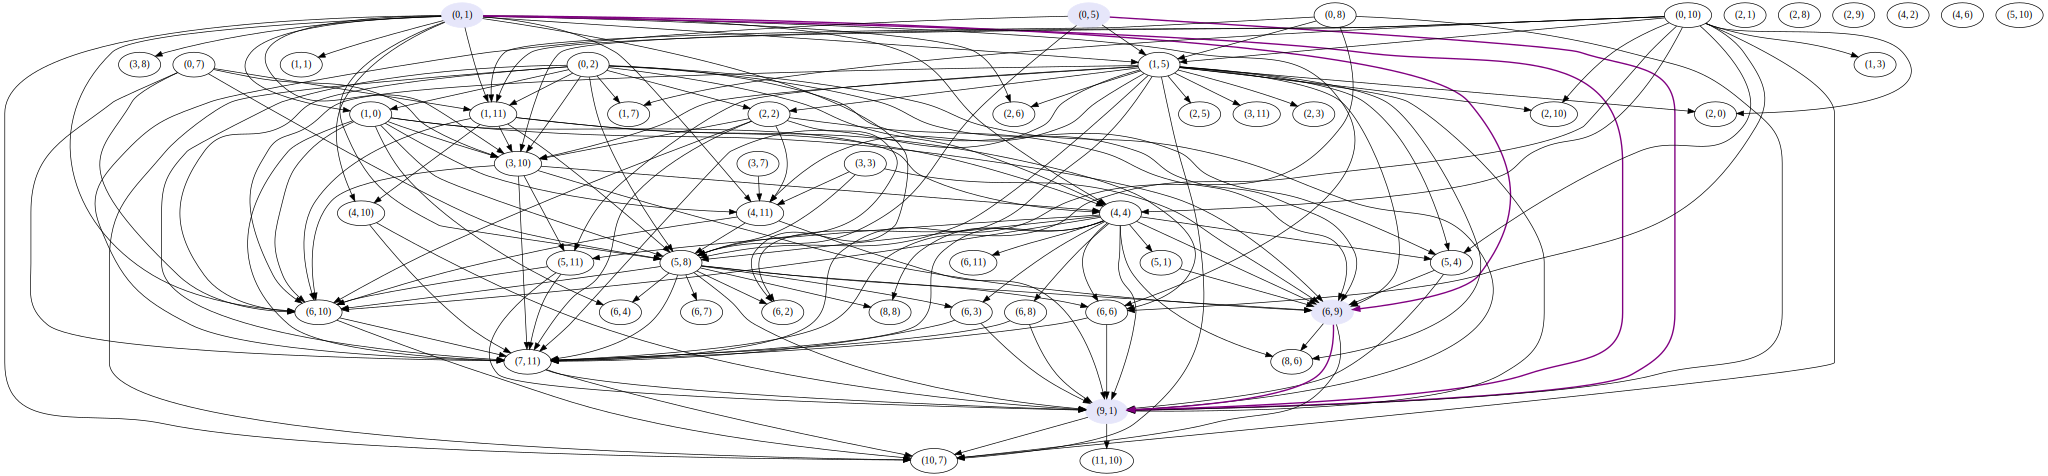

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plot_graph_adjacency(head_adjList, filename="circuit_graph_top"+str(topperc)+"_perc", highlighted_nodes=greater_than)

In [ ]:
import pickle

with open("results_dict.pkl", "wb") as file:
    pickle.dump(results_dict, file)
files.download("results_dict.pkl")

with open("head_adjList.pkl", "wb") as file:
    pickle.dump(head_adjList, file)
files.download("head_adjList.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## iter patch from 80% bf moredata incorr i+3

https://colab.research.google.com/drive/1WsZXGXtWLHdvkP93Qd4jenE1kzKySz9o#scrollTo=04ILHSBb0qT4&line=4&uniqifier=1

In [ ]:
circuit = [(0, 1), (0, 2), (0, 5), (0, 7), (0, 8), (0, 10), (1, 0), (1, 1), (1, 5), (1, 7), (1, 11), (2, 0), (2, 1), (2, 2), (2, 3), (2, 6), (2, 8), (2, 9), (2, 10), (2, 11), (3, 3), (3, 4), (3, 5), (3, 7), (3, 8), (3, 9), (3, 11), (4, 4), (4, 10), (5, 1), (5, 4), (5, 6), (5, 8), (5, 11), (6, 4), (6, 6), (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (7, 11), (9, 1)]
topperc = 5

In [ ]:
%%capture
results_dict = {}
for head in circuit:
    model.reset_hooks()
    result = get_path_patch_head_to_heads(
        receiver_heads = [head],
        receiver_input = "v",
        model = model,
        patching_metric = ioi_metric_2
    )
    results_dict[head] = result

In [ ]:
def thres_at_perc(results_dict, perc):
    # the top perc%
    all_values = []
    for result_tensor in results_dict.values():
        all_values.extend(result_tensor.cpu().numpy().flatten())
    sorted_values = sorted(all_values)

    ind_perc = (100 - perc)/100

    # Calculate the index for the top %
    index_percent = int(ind_perc * len(sorted_values))

    # Retrieve the value at that index
    value_at_percent = sorted_values[index_percent]
    return value_at_percent

In [ ]:
%%capture
Ethres = thres_at_perc(results_dict, topperc)

head_adjList = {}
for head in circuit:
    result = results_dict[head]
    head_adjList[head] = edges_within_threshold(result, Ethres)

In [ ]:
# only keep nodes that were part of original circuit
all_keys = set(head_adjList.keys())
# Iterate through the dictionary and filter the list values
for key, value in head_adjList.items():
    head_adjList[key] = [item for item in value if item in all_keys]

In [ ]:
# Filter out nodes that don't have outgoing edges except for (9,1) and (10, 7)
# head_adjList = {node: neighbors for node, neighbors in head_adjList.items() if neighbors or node == (9,1) or node == (10,7)}

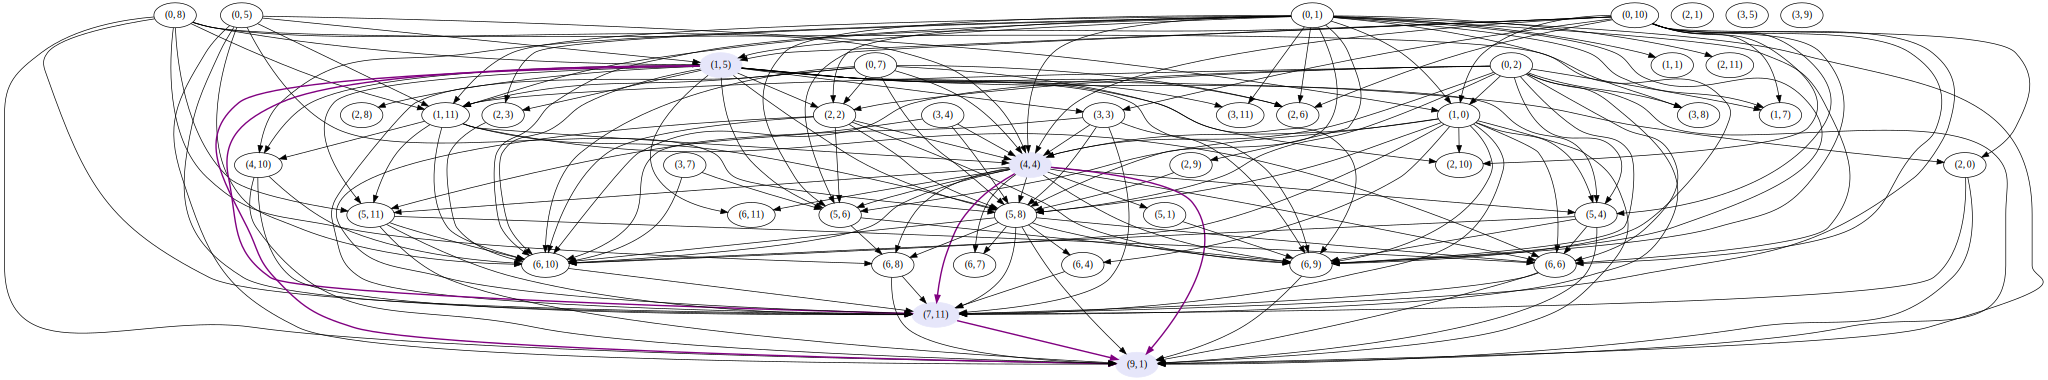

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plot_graph_adjacency(head_adjList, filename="circuit_graph_top"+str(topperc)+"_perc", highlighted_nodes=[(1,5), (4,4), (7,11), (9,1)])

In [ ]:
import pickle

with open("results_dict.pkl", "wb") as file:
    pickle.dump(results_dict, file)
files.download("results_dict.pkl")

with open("head_adjList.pkl", "wb") as file:
    pickle.dump(head_adjList, file)
files.download("head_adjList.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>